In [10]:
import warnings
warnings.filterwarnings("ignore")

In [146]:
# Importing packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score

In [12]:
%matplotlib inline
plt.style.use('bmh')

In [19]:
# self created packages
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from scripts.visualizations import Visualization
from scripts.snowflake_sink import SnowflakeConnector

In [122]:
# pyspark packages
from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col, sum, desc, explode, split, year, month, dayofweek, length, initcap, trim, lower, 
    regexp_extract, regexp_replace, max, explode, count, when, concat_ws)
from pyspark.sql.types import (
    StructType, StructField, IntegerType, StringType,
    FloatType, BooleanType, DateType, DoubleType)

# pyspakr ML library
from pyspark.ml.feature import VectorAssembler, ChiSqSelector, StringIndexer
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml import Pipeline

In [23]:
spark = SparkSession.builder \
    .appName("Data Modeling") \
    .getOrCreate()

spark

24/11/03 12:03:55 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [28]:
ip_data = spark.read.option("header", "True") \
                .option("inferSchema", "True") \
                .option("quote", '"') \
                .option("escape", '"') \
                .option("sep", ",") \
                .option("ignoreLeadingWhiteSpace", "True") \
                .option("ignoreTrailingWhiteSpace", "True") \
                .option("multiLine", "True") \
                .option("mode", "PERMISSIVE") \
                .csv("../data/gun_violence_cleaned_data_2013_2018.csv")

print(f"Number of records in the data : {ip_data.count()}")
print(f"Number of columns: {len(ip_data.columns)}")

Number of records in the data : 239677
Number of columns: 45


In [30]:
txt_columns = ["notes"]

ip_data = ip_data.fillna("missing", subset=txt_columns)

### Classification (without the text column)

For startes we are setting the target column as `is_killed` a new column created and proceed with the classification problem.

We will also drop features such as `incident_id`, `notes`, `date`, `city_or_county`, and may be `incident_characteristics`, `year`

Not sure if `year` is needed as it might be missleading.

In [82]:
class_ip_data = ip_data.withColumn("is_killed", when(col("n_killed") > 0, 1).otherwise(0))

Dropping columns which we won't be using.

In [85]:
cols_to_drop = ["n_killed", "incident_id", "date", "address", "congressional_district", "incident_characteristics", "latitude", "longitude", "notes"]

class_ip_data = class_ip_data.drop(*cols_to_drop)

In [107]:
non_numeric_columns = [field.name for field in class_ip_data.schema.fields if not isinstance(field.dataType, (IntegerType, FloatType, DoubleType))]

print("Non-integer and non-float columns:", non_numeric_columns)

Non-integer and non-float columns: []


In [93]:
def encode_multiple_columns_with_string_indexer(df, columns):
    """
    Function to encode multiple columns using StringIndexer.
    
    Parameters:
    df (DataFrame): The input DataFrame.
    columns (list): List of column names to be indexed.
    
    Returns:
    DataFrame: DataFrame with the new indexed columns.
    """
    indexers = [StringIndexer(inputCol=col, outputCol=col + "_indexed") for col in columns]
    pipeline = Pipeline(stages=indexers)
    indexed_df = pipeline.fit(df).transform(df)
    
    return indexed_df

In [97]:
class_ip_data = encode_multiple_columns_with_string_indexer(class_ip_data, non_numeric_columns)

In [101]:
class_ip_data = class_ip_data.drop(*non_numeric_columns)

class_ip_data = class_ip_data.withColumnRenamed('state_indexed', 'state') \
                            .withColumnRenamed('city_or_county_indexed', 'city_or_county')

#### Feature Vectorization

In [111]:
feature_columns = [col for col in class_ip_data.columns if col not in ['is_killed']]

assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
class_ip_data = assembler.transform(class_ip_data).select("features", "is_killed")

In [115]:
# Splitting data into training and testing sets
train_data, test_data = class_ip_data.randomSplit([0.8, 0.2], seed=42)

#### Model Training and Evaluation

##### Randon Forest

In [126]:
rf = RandomForestClassifier(labelCol="is_killed", featuresCol="features", maxBins=15000)

paramGrid_rf = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 20]) \
    .addGrid(rf.maxDepth, [5, 10]) \
    .build()

crossval_rf = CrossValidator(estimator=rf, estimatorParamMaps=paramGrid_rf,
                             evaluator=BinaryClassificationEvaluator(labelCol="is_killed", metricName="areaUnderROC"),
                             numFolds=3)

rf_model = crossval_rf.fit(train_data)

rf_predictions = rf_model.transform(test_data)
evaluator = BinaryClassificationEvaluator(labelCol="is_killed", metricName="areaUnderROC")
rf_auc = evaluator.evaluate(rf_predictions)
print(f"Random Forest AUC: {rf_auc}")

24/11/03 13:27:29 WARN CacheManager: Asked to cache already cached data.
24/11/03 13:27:29 WARN CacheManager: Asked to cache already cached data.
24/11/03 13:28:18 WARN DAGScheduler: Broadcasting large task binary with size 1063.2 KiB
24/11/03 13:28:34 WARN DAGScheduler: Broadcasting large task binary with size 1257.8 KiB
24/11/03 13:28:43 WARN DAGScheduler: Broadcasting large task binary with size 1322.4 KiB
24/11/03 13:29:04 WARN DAGScheduler: Broadcasting large task binary with size 1439.2 KiB
24/11/03 13:29:29 WARN DAGScheduler: Broadcasting large task binary with size 1526.6 KiB
24/11/03 13:29:59 WARN DAGScheduler: Broadcasting large task binary with size 1490.7 KiB
24/11/03 13:30:07 WARN DAGScheduler: Broadcasting large task binary with size 1081.9 KiB
24/11/03 13:30:18 WARN DAGScheduler: Broadcasting large task binary with size 1375.4 KiB
24/11/03 13:30:31 WARN DAGScheduler: Broadcasting large task binary with size 1835.0 KiB
24/11/03 13:30:46 WARN DAGScheduler: Broadcasting lar

Random Forest AUC: 0.9999966725808476


In [142]:
preds_df = rf_predictions.select("is_killed", "probability").toPandas()

preds_df["probability"] = preds_df["probability"].apply(lambda x: x[1])
true_labels = preds_df["is_killed"]
predicted_probs = preds_df["probability"]

24/11/03 14:02:49 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB


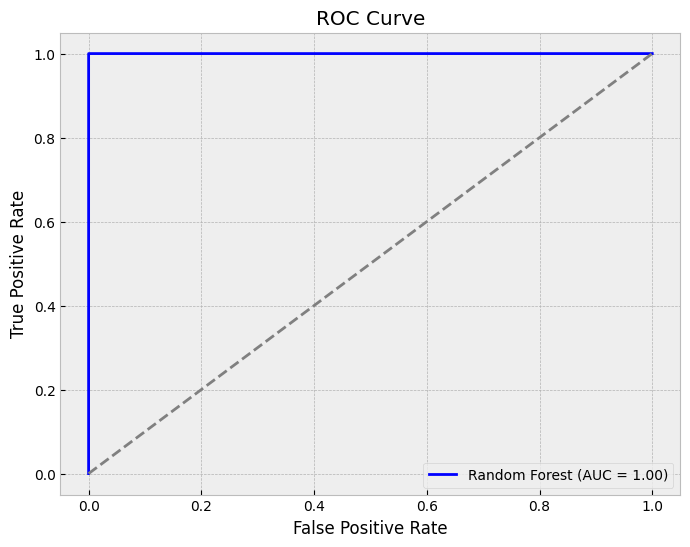

In [144]:
fpr, tpr, thresholds = roc_curve(true_labels, predicted_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", label=f"Random Forest (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

In [148]:
preds_df["predicted_label"] = (predicted_probs >= 0.5).astype(int)

accuracy = accuracy_score(true_labels, preds_df["predicted_label"])
precision = precision_score(true_labels, preds_df["predicted_label"])
recall = recall_score(true_labels, preds_df["predicted_label"])
f1 = f1_score(true_labels, preds_df["predicted_label"])

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.9999
Precision: 0.9997
Recall: 1.0000
F1 Score: 0.9999


This might be overfitting we have to see.